In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import sys

from tqdm.notebook import tqdm
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preparing Metadata/Labels

In [3]:
all_files = pd.DataFrame(glob.glob("/mnt/b/Git_Projects/Biospec_Analysis/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])
all_files["TMA"] = all_files.apply(lambda row: float(row["hdf_loc"].split("/")[-1][4:5]), axis = 1)
all_files["Core"] = all_files.apply(lambda row: row["hdf_loc"].split("/")[-1][8:-7], axis = 1)

In [4]:
metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx"
              , sheet_name = "reformatted")

metadata = metadata.merge(all_files, left_on = ["TMA", "TMA site"], right_on = ["TMA", "Core"])

In [5]:
metadata.head()

,TMA,TMA site,gender,Patient nu,Corrected Site AJCC/UICC,Pathogical Stage,T stage,N stage,ECS,diff,advancing front type,Overall Death,survival (months),recurrence,radiotherapy,Diagnosis Age,hdf_loc,Core
0,2.0,G9,m,3238,other,pT4N0M0,4,0,no,mod,cords/islands,no,63.0,no,yes,71.0,/mnt/b/Git_Projects/Biospec_Analysis/Extracted...,G9
1,2.0,F10,f,3252,FOM,pT4N1M0,4,1,yes,mod,cords/islands,no,123.0,no,yes,61.0,/mnt/b/Git_Projects/Biospec_Analysis/Extracted...,F10
2,2.0,G11,m,3277,oropharynx,pT2N2bM0,2,2b,no,mod,islands/islets,no,99.0,no,yes,56.0,/mnt/b/Git_Projects/Biospec_Analysis/Extracted...,G11
3,2.0,F2,m,3318,oral tongue,pT3N0M0,3,0,no,mod,non cohesive,no,94.0,no,yes,58.0,/mnt/b/Git_Projects/Biospec_Analysis/Extracted...,F2
4,2.0,A8,f,3354,oral tongue,pT2N1Mx,2,1,no,well,non-cohesive,no,103.0,no,no,48.0,/mnt/b/Git_Projects/Biospec_Analysis/Extracted...,A8


In [98]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer, PowerTransformer, QuantileTransformer, MaxAbsScaler
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from sklearn.kernel_approximation import RBFSampler, Nystroem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score

from sklearn.multiclass import OneVsRestClassifier

from mlxtend.evaluate import scoring

# Import data and preprocess

In [7]:
from Preprocessing_Methods import *

import sys

sys.path.append("/mnt/b/Git_Projects/Biospec_Analysis/UNET")

In [10]:
select = ['Paraffin']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue not in {select}").sample(frac = 0.2), start = 0, end = 4000, paraffin = None)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"]).drop(np.nan, level = "ECS").sample(frac = 0.1)

In [11]:
select = ['Paraffin']

paraffin = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue in {select}").sample(frac = 0.2), start = 0, end = 4000, paraffin = None)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"]).drop(np.nan, level = "ECS").sample(frac = 0.1)

In [306]:
steps = [
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    #("Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
    #("Normalise spectra", FunctionTransformer(minmax_scale, kw_args = {"axis": 0})),
    ("Scaler", RobustScaler()),
    #("MinMax", StandardScaler()),
    #("MinMax", PowerTransformer()),
    #("MaxAbs", QuantileTransformer()),
    #("MaxAbs", MinMaxScaler()),

    ("PCA", PCA())
]


tissuepipe = Pipeline(steps).fit(total.append(paraffin))


In [319]:
corrected = pd.DataFrame(tissuepipe.inverse_transform(tissuepipe.transform(total) / tissuepipe.transform(paraffin).mean(axis = 0))
                         , columns = total.columns
                         , index = total.index)

In [320]:
check = pd.DataFrame(tissuepipe.inverse_transform(tissuepipe.transform(paraffin) / tissuepipe.transform(paraffin).mean(axis = 0))
                         , columns = paraffin.columns
                         , index = paraffin.index)

In [316]:
totalpca = pd.DataFrame(tissuepipe.transform(total), index = total.index)
paraffinpca = pd.DataFrame(tissuepipe.transform(paraffin), index = paraffin.index)

correctedpca = pd.DataFrame(tissuepipe.transform(total) / tissuepipe.transform(paraffin).mean(axis = 0), index = total.index)
checkpca = pd.DataFrame(tissuepipe.transform(paraffin) / tissuepipe.transform(paraffin).mean(axis = 0), index = paraffin.index)

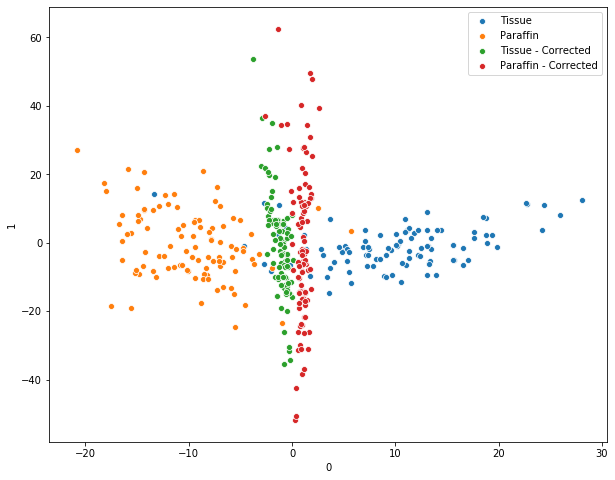

In [326]:
fig, ax = plt.subplots(figsize = (10,8))

sns.scatterplot(x = 0, y = 1, data = totalpca.sample(100), label = "Tissue", ax = ax)
sns.scatterplot(x = 0, y = 1, data = paraffinpca.sample(100), label = "Paraffin", ax = ax)
sns.scatterplot(x = 0, y = 1, data = correctedpca.sample(100), label = "Tissue - Corrected", ax = ax)
sns.scatterplot(x = 0, y = 1, data = checkpca.sample(100), label = "Paraffin - Corrected", ax = ax)

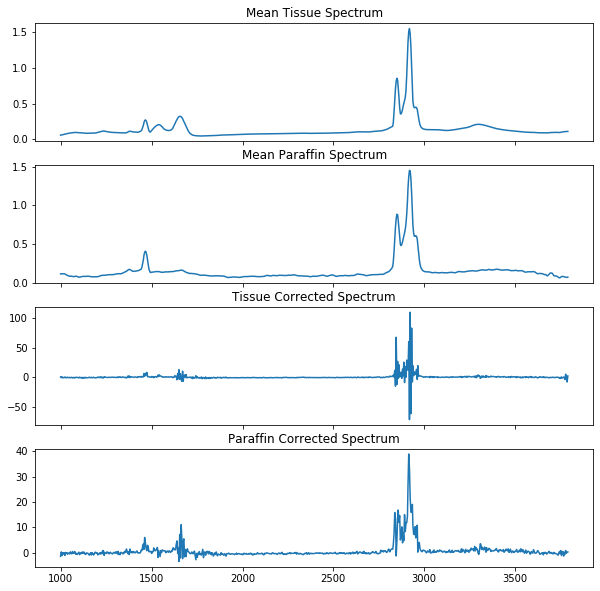

In [321]:
#minmax, robust, /
# Both scalers on 1,1 axes

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (10,10), sharex = True)

ax1.set_title("Mean Tissue Spectrum")
total.mean(axis = 0).T.plot(ax = ax1)

ax2.set_title("Mean Paraffin Spectrum")
paraffin.mean(axis = 0).T.plot(ax = ax2)

ax3.set_title("Tissue Corrected Spectrum")
corrected.mean(axis = 0).T.plot(ax = ax3)

ax4.set_title("Paraffin Corrected Spectrum")
check.mean(axis = 0).T.plot(ax = ax4)

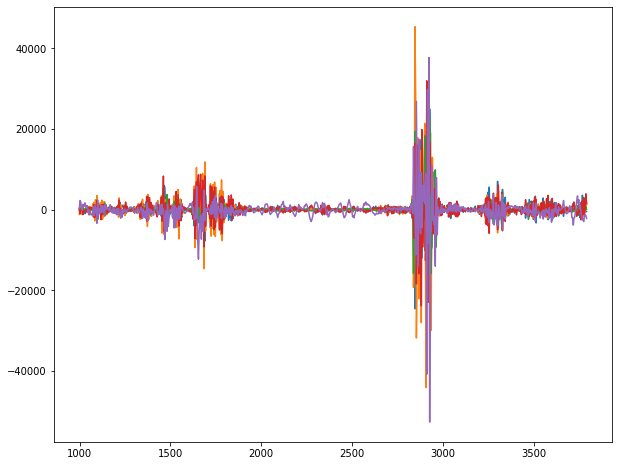

In [343]:
corrected.sample(5).T.plot(legend = False, figsize = (10,8))

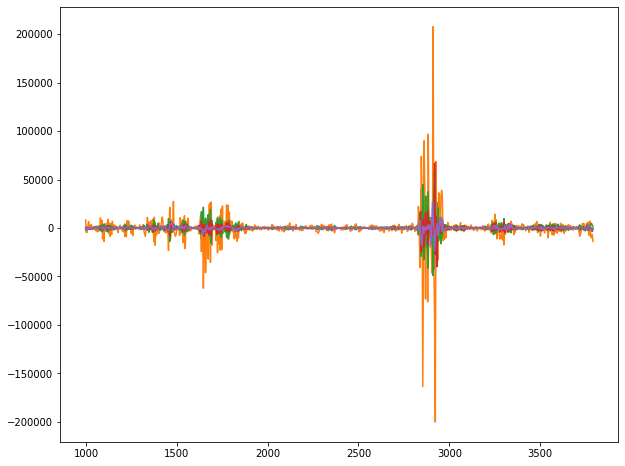

In [335]:
check.sample(5).T.plot(legend = False, figsize = (10,8))

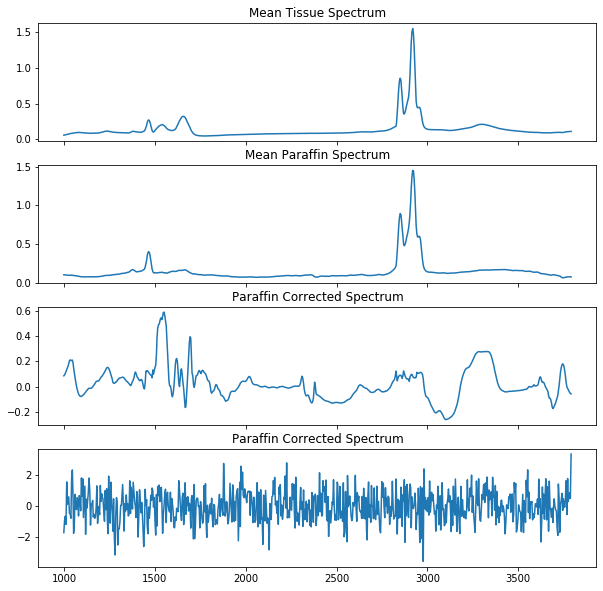

In [22]:
#minmax, robust, /

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (10,10), sharex = True)

ax1.set_title("Mean Tissue Spectrum")
total.mean(axis = 0).T.plot(ax = ax1)

ax2.set_title("Mean Paraffin Spectrum")
paraffin.mean(axis = 0).T.plot(ax = ax2)

ax3.set_title("Paraffin Corrected Spectrum")
corrected.mean(axis = 0).T.plot(ax = ax3)

ax4.set_title("Paraffin Corrected Spectrum")
check.mean(axis = 0).T.plot(ax = ax4)

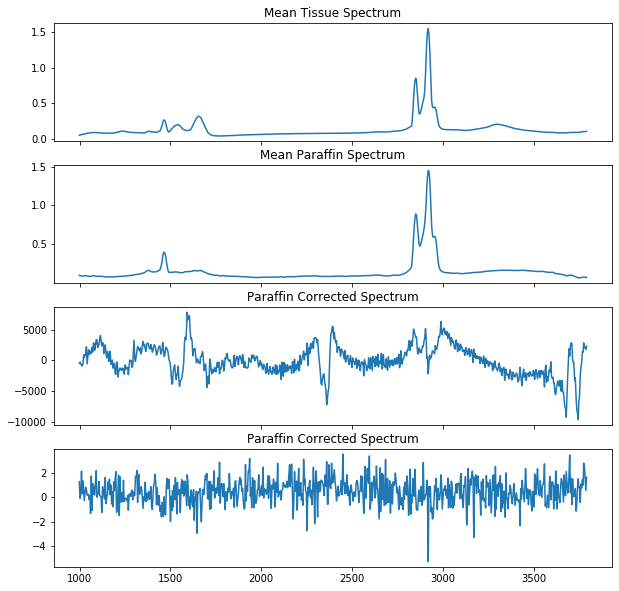

In [35]:
#minmax, robust, /

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (10,10), sharex = True)

ax1.set_title("Mean Tissue Spectrum")
total.mean(axis = 0).T.plot(ax = ax1)

ax2.set_title("Mean Paraffin Spectrum")
paraffin.mean(axis = 0).T.plot(ax = ax2)

ax3.set_title("Paraffin Corrected Spectrum")
corrected.mean(axis = 0).T.plot(ax = ax3)

ax4.set_title("Paraffin Corrected Spectrum")
check.mean(axis = 0).T.plot(ax = ax4)

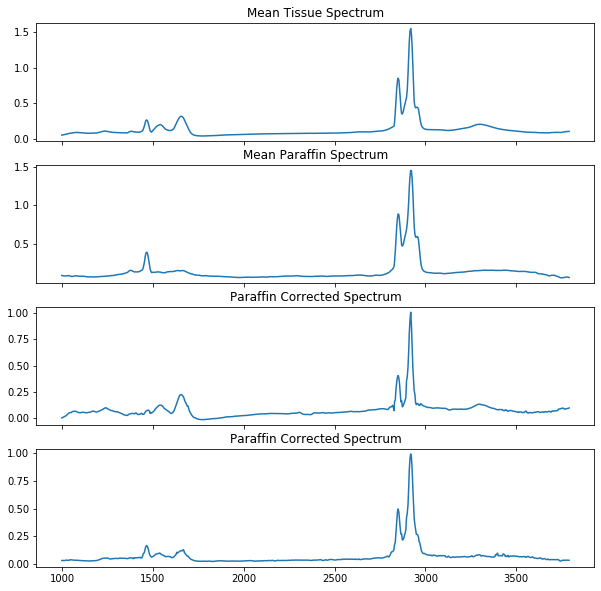

In [26]:
#Minmax, -

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (10,10), sharex = True)

ax1.set_title("Mean Tissue Spectrum")
total.mean(axis = 0).T.plot(ax = ax1)

ax2.set_title("Mean Paraffin Spectrum")
paraffin.mean(axis = 0).T.plot(ax = ax2)

ax3.set_title("Paraffin Corrected Spectrum")
corrected.mean(axis = 0).T.plot(ax = ax3)

ax4.set_title("Paraffin Corrected Spectrum")
check.mean(axis = 0).T.plot(ax = ax4)